In [ ]:
import sys
sys.path.append('../src')
from utils import parse_openfoam_case

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

In [ ]:
# foil_model = 'stars'
# foil_model = 'eclipse'
foil_model = 'namdar'

nsamples = 100
nthreads = 4

quantile_hdi = 0.95

experiment_name = f'foil_lyu2021_c4_{foil_model}'

nsamples = 100

In [117]:
dt = 250
T = 30000
time_steps = T//dt

df_samples = []
for i in tqdm(range(nsamples), desc='Reading simulation data'):
    case_dir = f'../simulator/experiments/{experiment_name}/sample_{i:03d}'
    df_sample = parse_openfoam_case(case_dir, variables=['Fa', 'Fb'], time_dirs=[str(i) for i in range(dt, T+1, dt)])
    df_samples.append(df_sample)

Reading simulation data: 100%|██████████| 100/100 [01:23<00:00,  1.20it/s]


In [118]:
ut = 1.1362179991715267e-05 + 2.7488200082847322e-06

prod_w = np.zeros((nsamples, time_steps))
prod_o = np.zeros((nsamples, time_steps))
prod_g = np.zeros((nsamples, time_steps))

for k, df_sample in tqdm(enumerate(df_samples)):
    
    aux_df = df_sample.copy()
    aux_df.rename(columns={'Fa': 'Fg', 'Fb': 'Fw'}, inplace=True)
    aux_df['Fo'] = 1 - aux_df['Fg'] - aux_df['Fw']

    for col in aux_df.columns:
        aux_df[col] = aux_df[col].apply(lambda x: x[-5])
        aux_df[col] = aux_df[col] * ut      # velocity of the phase
    
    for j in range(1, time_steps):
        prod_w[k, j] = np.trapz(aux_df['Fw'].iloc[:j], dx=dt)
        prod_o[k, j] = np.trapz(aux_df['Fo'].iloc[:j], dx=dt)
        prod_g[k, j] = np.trapz(aux_df['Fg'].iloc[:j], dx=dt)


100it [00:01, 56.21it/s]


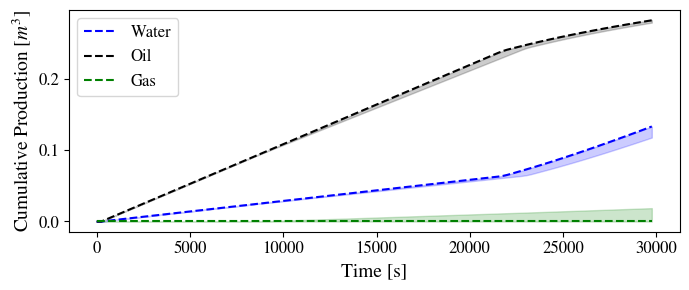

In [119]:
times = np.arange(0, T, dt)

prod_w_m = np.median(prod_w, axis=0)
prod_o_m = np.median(prod_o, axis=0)
prod_g_m = np.median(prod_g, axis=0)

prod_w_ql = np.quantile(prod_w, 0.1, axis=0)
prod_o_ql = np.quantile(prod_o, 0.1, axis=0)
prod_g_ql = np.quantile(prod_g, 0.1, axis=0)

prod_w_qu = np.quantile(prod_w, 0.9, axis=0)
prod_o_qu = np.quantile(prod_o, 0.9, axis=0)
prod_g_qu = np.quantile(prod_g, 0.9, axis=0)


# 3 axes 
# fig, axs = plt.subplots(1, 3, figsize=(12, 3))
plt.figure(figsize=(7, 3))

plt.plot(times, prod_w_m, '--', label='Water', color='blue')
plt.plot(times, prod_o_m, '--', label='Oil', color='black')
plt.plot(times, prod_g_m, '--', label='Gas', color='green')

plt.fill_between(times, prod_w_ql, prod_w_qu, color='blue', alpha=0.2)
plt.fill_between(times, prod_o_ql, prod_o_qu, color='black', alpha=0.2)
plt.fill_between(times, prod_g_ql, prod_g_qu, color='green', alpha=0.2)

plt.xlabel('Time [s]', fontsize=14)
plt.xlabel('Time [s]', fontsize=14)
plt.xlabel('Time [s]', fontsize=14)
plt.ylabel('Cumulative Production [$m^3$]', fontsize=14)

plt.tick_params(axis='both', which='major', labelsize=12)

for ax in axs:
    plt.legend(loc='upper left', fontsize=12)

plt.tight_layout()
plt.savefig(f'../data/plots/{experiment_name}_cumulative_production.pdf')